In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import algorithms.calibrate_camera as calibrate_camera
import algorithms.image_transformations as image_transformations


## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

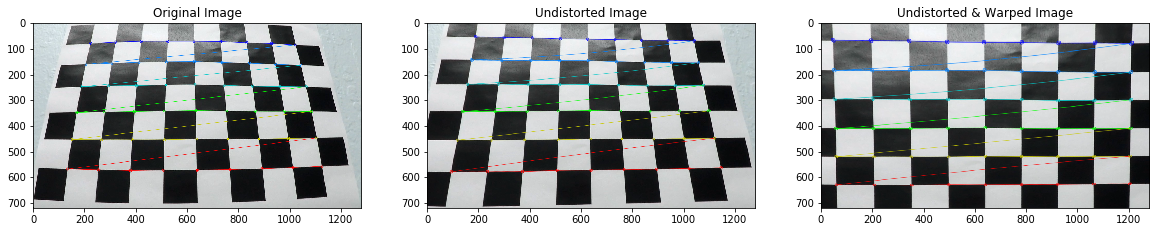

In [ ]:
cemera_caliration_path = 'camera_cal/calibration3.jpg'
img, mtx, dist_coef = calibrate_camera.undistort_and_warp(cemera_caliration_path)

## Apply a distortion correction and perspective transform

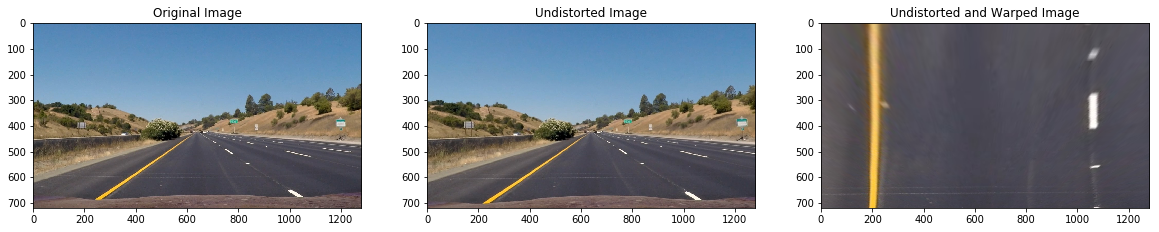

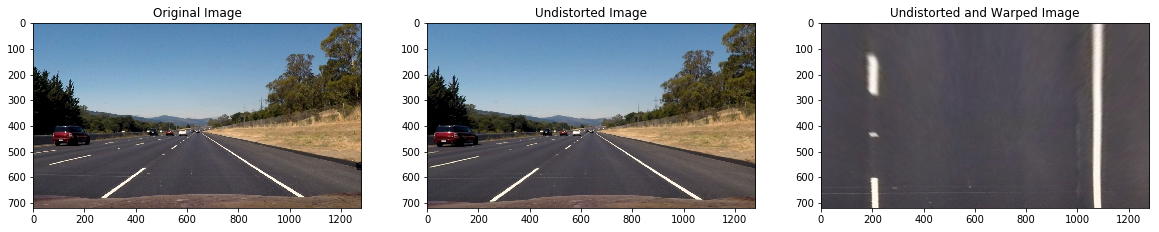

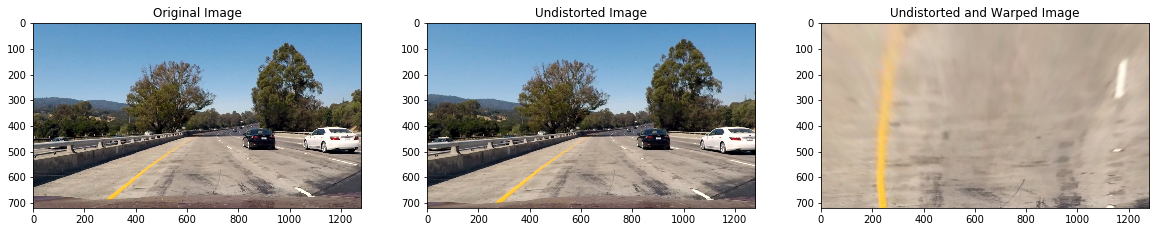

In [ ]:
import algorithms.image_transformations as image_transformations

test_images = glob.glob('test_images/*.jpg')
test_images_warped = []

for image in test_images:
    # Read image and transform to RGB first
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undist = image_transformations.undistort_image(img, mtx, dist_coef)
    
    src_points = [(290, 660), (1020, 660), (595, 450), (690, 450)]
    dst_points = [(200, 720), (1080, 720), (200, -500), (1080, -500)]

    img_warped, M, M_inv = image_transformations.warp_image(img_undist, src_points, dst_points)
    test_images_warped.append(img_warped)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(img_undist)
    ax2.set_title('Undistorted Image')
    ax3.imshow(img_warped)
    ax3.set_title('Undistorted and Warped Image')

## Use color mask and Sobel filter to create a thresholded binary image.

In [ ]:
# Color mask
for image in test_images_warped:
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Define thresholds for white lines
    white_hsv_low  = np.array([ 0,   0,   250])
    white_hsv_high = np.array([ 255,  80, 255])

    # Define thresholds for yellow lines
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    
    img_mask_white, img_white = image_transformations.color_mask(img_hsv, image, white_hsv_low, white_hsv_high)
    img_mask_yellow, img_yellow = image_transformations.color_mask(img_hsv, image, yellow_hsv_low, yellow_hsv_high)
    
    img_color = cv2.bitwise_or(img_white, img_yellow)
    img_mask = cv2.bitwise_or(img_mask_white, img_mask_yellow)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(img_white)
    ax2.set_title('White lanes')
    ax3.imshow(img_yellow)
    ax3.set_title('Yellow lanes')
    ax4.imshow(img_color)
    ax4.set_title('Color Masks combined')

In [ ]:
#Sobel filter

kernel_size = 9
    
for image in test_images_warped:

    img_blur = image_transformations.gaussian_blur(image, kernel=kernel_size)
    img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    img_gs = img_hls[:, :, 1]
    img_abs_x = image_transformations.abs_sobel(img_gs,'x', 5, (50, 225))
    img_abs_y = image_transformations.abs_sobel(img_gs,'y', 5, (50, 225))
    
    img_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))
    
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(img_abs_x,cmap='gray')
    ax2.set_title('X direction')
    ax3.imshow(img_abs_y,cmap='gray')
    ax3.set_title('Y direction')
    ax4.imshow(img_sobel,cmap='gray')
    ax4.set_title('Sobel combined')

In [ ]:
# Combine masks

for image in test_images_warped:
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Define thresholds for white lines
    white_hsv_low  = np.array([ 0,   0,   250])
    white_hsv_high = np.array([ 255,  80, 255])

    # Define thresholds for yellow lines
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    
    img_mask_white, img_white = image_transformations.color_mask(img_hsv, image, white_hsv_low, white_hsv_high)
    img_mask_yellow, img_yellow = image_transformations.color_mask(img_hsv, image, yellow_hsv_low, yellow_hsv_high)
    
    img_color = cv2.bitwise_or(img_white, img_yellow)
    img_mask = cv2.bitwise_or(img_mask_white, img_mask_yellow)
    

    img_blur = image_transformations.gaussian_blur(image, kernel=kernel_size)
    img_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    img_gs = img_hls[:, :, 1]
    img_abs_x = image_transformations.abs_sobel(img_gs,'x', 5, (50, 225))
    img_abs_y = image_transformations.abs_sobel(img_gs,'y', 5, (50, 225))
    
    img_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))
    
    image_combined = np.zeros_like(img_sobel)
    image_combined[(img_mask>=.5)|(img_sobel>=.5)]=1
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(img_mask,cmap='gray')
    ax2.set_title('Color mask')
    ax3.imshow(img_sobel,cmap='gray')
    ax3.set_title('Sobel filter')
    ax4.imshow(image_combined,cmap='gray')
    ax4.set_title('Masks combined')

## Detect lane pixels and fit to find the lane boundary and determine the curvature of the lane and vehicle position with respect to center

In [ ]:
image_cmb1 = image_combined

img_size = np.shape(image)

image_cmb1 = image_transformations.gaussian_blur(image_cmb1,5) 
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2.:,:],axis=0)
mean_lane = image_transformations.moving_average(mean_lane,mov_filtsize)

plt.subplot(2, 1, 1)
plt.imshow(image_cmb1[img_size[0]/2.:,:],cmap='gray')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

In [ ]:
out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = \
                                                    image_transformations.image_hist(image_cmb1)

In [ ]:
binary_warped = image_cmb1

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(num=None, figsize=(10, 20))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [ ]:
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

## Draw lines on original image (undistorted)

In [ ]:
warped = image_cmb1

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)